# Workflow for the calibration and the analysis of a population-average model 

1. Parameter estimation using Maximum Likelihood Estimation
2. Calculation of Profile Likelihoods for each parameter
3. MCMC sampling
4. Sobol analysis

The pypesto ecosystem (https://pypesto.readthedocs.io/en/latest/index.html) is used to perform parameter estimation, profile likelihoods and MCMC sampling

In [1]:
import pypesto
import pypesto.optimize as optimize
import pypesto.profile as profile
import pypesto.visualize as visualize
import pypesto.sample as sample
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from SALib.sample import saltelli
from SALib.analyze import sobol
import seaborn as sns

## Load pre-processed data

continous mean and standart deviation of BGS2 data

In [2]:
FSH_moving = pd.read_csv('DataPoints/FSH_rollingData.txt', header=None)
E2_moving = pd.read_csv('DataPoints/E2_rollingData.txt', header=None)
LH_moving = pd.read_csv('DataPoints/LH_rollingData.txt', header=None)

## Define model, parameters, inital condition

In [3]:
#start value originate from a differential evolution test run
P = {"k_syn_FSH": 49.49418845,
    "k_cl_FSH": 0.10008877, 
    "k_syn_E2": 12.95594545,
    "k_cl_E2": 0.10001612,
    "T_FSH_E2": 2.86346153,
    "n_FSH_E2": 5.20396759,
    "k_syn_LH": 0.10001534,
    "k_cl_LH": 0.53593832,
    "T_E2_LH": 0.10587896,
    "n_E2_LH": 2.19039377, 
    "log_growth": 0.37592248, 
    "log_mid": 19.83817588}

y_data = [FSH_moving[1].values, E2_moving[1].values, LH_moving[1].values]
t_data  = [FSH_moving[0].values, E2_moving[0].values, LH_moving[0].values]
sigma_data = [FSH_moving[2].values, E2_moving[2].values, LH_moving[2].values]

t_eval = np.concatenate((FSH_moving[0].values, E2_moving[0].values, LH_moving[0].values))
t_eval = np.unique(t_eval)
y0 = [y_data[0][0], y_data[1][0], y_data[2][0]] 
t_init = 7.5
t_final = 11.5
t_span = [t_init, t_final]

def dy_dt(t, y):
    
    FSH, E2, LH = y
    
    dFSH = P['k_syn_FSH'] * (1/(1 + np.exp(-P['log_growth']*(t - P['log_mid'])))) - P['k_cl_FSH']*FSH
    dE2 = P['k_syn_E2'] * ((FSH/P['T_FSH_E2'])**P['n_FSH_E2'])/(1+(FSH/P['T_FSH_E2'])**P['n_FSH_E2']) - P['k_cl_E2']*E2
    dLH = P['k_syn_LH'] * (1/(1 + np.exp(-P['log_growth']*(t - P['log_mid'])))) * ((E2/P['T_E2_LH'])**P['n_E2_LH'])/(1+(E2/P['T_E2_LH'])**P['n_E2_LH']) - P['k_cl_LH']*LH

    dydt = [dFSH, dE2, dLH]
    return dydt

## Define likelihood function for MLE and MCMC

In [4]:
def Objective(sol_y, sol_t, y_data, t_data, sigma_data):

    H = np.zeros(1)
    
    for j in range(np.shape(y_data)[0]):
        for i in range(len(y_data[j])):
            t_index = np.where(sol_t == t_data[j][i])
            H[0] += (1/sigma_data[j][i]**2)*(y_data[j][i] - sol_y[j][t_index])**2
    
    return H

def CalcObjective(x):
    # x = [k_syn_FSH, k_cl_FSH, ...]
    # args = [y_data, t_data]
    P["k_syn_FSH"] = x[0]
    P["k_cl_FSH"] = x[1]
    P["k_syn_E2"] = x[2]
    P["k_cl_E2"] = x[3]
    P["T_FSH_E2"] = x[4]
    P["n_FSH_E2"] = x[5]
    P["k_syn_LH"] = x[6]
    P["k_cl_LH"] = x[7]
    P["T_E2_LH"] = x[8]
    P["n_E2_LH"] = x[9]
    P["log_growth"] = x[10]
    P["log_mid"] = x[11]

    sol = solve_ivp(dy_dt, t_span, y0, t_eval=t_eval)
    
    return float(Objective(sol.y, sol.t, y_data, t_data, sigma_data))

## MLE: multi-start optimisation

In [5]:
#set number of starts - 500 for publication 
n_starts = 100

In [6]:
custom_objective = pypesto.Objective(fun=CalcObjective, grad='3-point')

lb = np.array([0.001, 0.0000001, 0.001, 0.0000001, 0.001, 1.0, 0.001, 0.001, 0.001, 1.0, 0.001, 5.0])
ub = np.array([150.0, 150.0, 150.0, 150.0, 20.0, 5.0, 150.0, 150.0, 10.0, 5.0, 10.0, 25.0])

problem = pypesto.Problem(objective=custom_objective, lb=lb, ub=ub)
optimizer = optimize.ScipyOptimizer(method='L-BFGS-B')

history_options = pypesto.HistoryOptions(trace_record=True)

result = optimize.minimize(problem=problem,optimizer=optimizer,n_starts=n_starts,
                              history_options=history_options,filename=None,)

  0%|          | 0/100 [00:00<?, ?it/s]Executing task 0.
Final fval=226.2890, time=46.7964s, n_fval=1586.
  1%|          | 1/100 [00:46<1:17:13, 46.80s/it]Executing task 1.
Final fval=7.7891, time=111.1709s, n_fval=8463.
  2%|▏         | 2/100 [02:37<2:18:17, 84.67s/it]Executing task 2.
Final fval=11.4241, time=59.8068s, n_fval=4459.
  3%|▎         | 3/100 [03:37<1:58:31, 73.32s/it]Executing task 3.
Final fval=226.2890, time=17.7002s, n_fval=637.
  4%|▍         | 4/100 [03:55<1:22:10, 51.36s/it]Executing task 4.
Final fval=7.7225, time=232.0591s, n_fval=15002.
  5%|▌         | 5/100 [07:47<3:04:29, 116.52s/it]Executing task 5.
Final fval=226.2890, time=23.4216s, n_fval=767.
  6%|▌         | 6/100 [08:10<2:12:57, 84.87s/it] Executing task 6.
Final fval=138.9546, time=65.1151s, n_fval=2106.
  7%|▋         | 7/100 [09:16<2:01:32, 78.41s/it]Executing task 7.
Final fval=1235.9633, time=25.3995s, n_fval=286.
  8%|▊         | 8/100 [09:41<1:34:21, 61.54s/it]Executing task 8.
Final fval=1091.4

 51%|█████     | 51/100 [1:00:33<1:08:01, 83.29s/it]Executing task 51.
Final fval=80.3306, time=39.2908s, n_fval=2665.
 52%|█████▏    | 52/100 [1:01:12<56:04, 70.09s/it]  Executing task 52.
Final fval=226.2890, time=9.3215s, n_fval=507.
 53%|█████▎    | 53/100 [1:01:21<40:37, 51.86s/it]Executing task 53.
Final fval=226.2890, time=16.5868s, n_fval=520.
 54%|█████▍    | 54/100 [1:01:38<31:38, 41.28s/it]Executing task 54.
Final fval=247.2776, time=13.1740s, n_fval=767.
 55%|█████▌    | 55/100 [1:01:51<24:38, 32.85s/it]Executing task 55.
Final fval=22.8693, time=181.2756s, n_fval=8307.
 56%|█████▌    | 56/100 [1:04:53<56:44, 77.38s/it]Executing task 56.
Final fval=420.5097, time=23.3609s, n_fval=780.
 57%|█████▋    | 57/100 [1:05:16<43:50, 61.17s/it]Executing task 57.
Final fval=1215.6915, time=13.1168s, n_fval=312.
 58%|█████▊    | 58/100 [1:05:29<32:43, 46.76s/it]Executing task 58.
Final fval=68.2859, time=22.0964s, n_fval=1248.
 59%|█████▉    | 59/100 [1:05:51<26:53, 39.36s/it]Executing

### convert optimisation results in data frame and plot

(0.0, 3.5)

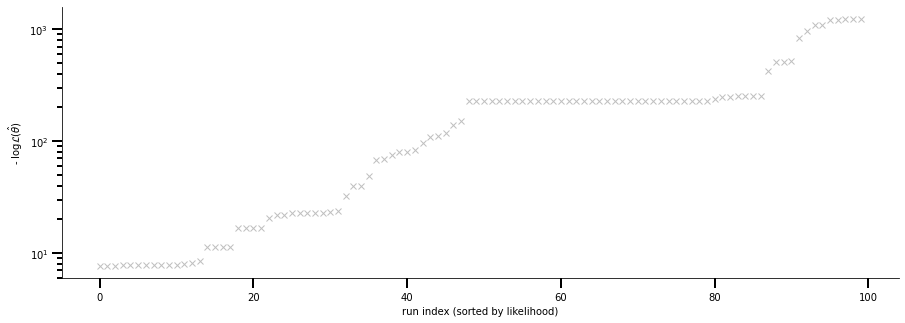

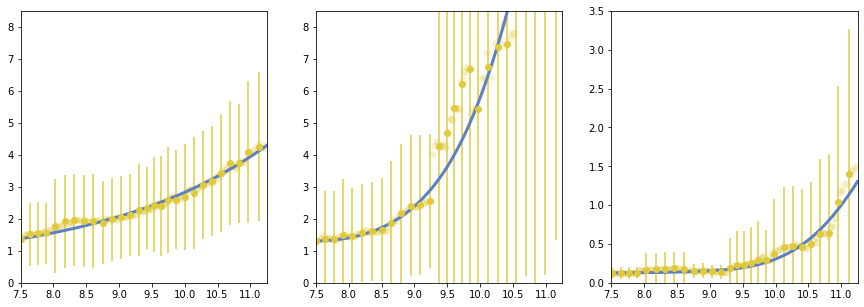

In [7]:
df_optiresults = result.optimize_result.as_dataframe(["x","fval","time", "grad", "x0", "exitflag"])

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(df_optiresults['fval'], 'x', color='grey', alpha=0.5)
plt.yscale("log")
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='out')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='out')
ax.yaxis.set_tick_params(which='minor', size=5, width=2, direction='out')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xlabel='run index (sorted by likelihood)', ylabel='- log$\mathcal{L}(\hat \\theta)$')

P['k_syn_FSH'] = df_optiresults.x[0][0]
P['k_cl_FSH'] = df_optiresults.x[0][1]
P["k_syn_E2"] = df_optiresults.x[0][2]
P["k_cl_E2"] = df_optiresults.x[0][3]
P["T_FSH_E2"] = df_optiresults.x[0][4]
P["n_FSH_E2"] = df_optiresults.x[0][5]
P["k_syn_LH"] = df_optiresults.x[0][6]
P["k_cl_LH"] = df_optiresults.x[0][7]
P["T_E2_LH"] = df_optiresults.x[0][8]
P["n_E2_LH"] = df_optiresults.x[0][9]
P["log_growth"] = df_optiresults.x[0][10]
P["log_mid"] = df_optiresults.x[0][11]
sol = solve_ivp(dy_dt, t_span, y0, t_eval=t_eval)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].scatter(t_data[0], y_data[0], color='#e0ca3cff', alpha=0.1)
#ax[0].scatter(FSH_all[0], FSH_all[1], color='grey', alpha=0.3, marker='x')
ax[0].errorbar(t_data[0][::10], y_data[0][::10], yerr=sigma_data[0][::10], color='#e0ca3cff', fmt="o")
ax[0].plot(sol.t, sol.y[0], color='#5d80c0ff', lw=3)
ax[0].set_xlim(7.5, 11.25)
ax[0].set_ylim(0.0, 8.5)

ax[1].scatter(t_data[1], y_data[1], color='#e0ca3cff', alpha=0.1)
#ax[1].scatter(E2_all[0], E2_all[1], color='grey', alpha=0.3, marker='x')
ax[1].errorbar(t_data[1][::10], y_data[1][::10], yerr=sigma_data[1][::10], color='#e0ca3cff', fmt="o")
ax[1].plot(sol.t, sol.y[1], color='#5d80c0ff', lw=3)
ax[1].set_xlim(7.5, 11.25)
ax[1].set_ylim(0.0, 8.5)

ax[2].scatter(t_data[2], y_data[2], color='#e0ca3cff', alpha=0.1)
#ax[2].scatter(LH_all[0], LH_all[1], color='grey', alpha=0.3, marker='x')
ax[2].errorbar(t_data[2][::10], y_data[2][::10], yerr=sigma_data[2][::10], color='#e0ca3cff', fmt="o")
ax[2].plot(sol.t, sol.y[2], color='#5d80c0ff', lw=3)
ax[2].set_xlim(7.5, 11.25)
ax[2].set_ylim(0.0, 3.5)

## Calculate and plot Profile Likelihoods

Note that the ML estimate used as start value for the calculation of PL can have an effect on the profiles

In [8]:
result = profile.parameter_profile(problem=problem, result=result, optimizer=optimizer, filename=None)

  0%|          | 0/12 [00:00<?, ?it/s]Executing task 0.
Final fval=7.6604, time=6.8463s, n_fval=912.
Final fval=7.6603, time=5.7509s, n_fval=768.
Final fval=7.6611, time=3.0807s, n_fval=408.
Final fval=7.6629, time=2.2559s, n_fval=300.
Final fval=7.6619, time=13.3948s, n_fval=1788.
Final fval=7.6624, time=9.9010s, n_fval=1320.
Final fval=7.6630, time=9.9736s, n_fval=1332.
Final fval=7.6651, time=5.0298s, n_fval=660.
Final fval=7.7054, time=1.3477s, n_fval=168.
Final fval=7.6631, time=8.3394s, n_fval=1104.
Final fval=7.6618, time=11.0588s, n_fval=1476.
Final fval=7.6606, time=13.8546s, n_fval=1836.
Final fval=7.6597, time=33.8636s, n_fval=4500.
Final fval=7.6677, time=6.7177s, n_fval=888.
Final fval=7.6784, time=17.8535s, n_fval=2376.
Final fval=7.6832, time=22.4164s, n_fval=2976.
Final fval=7.6864, time=22.3517s, n_fval=2964.
Final fval=7.6905, time=13.4400s, n_fval=1776.
Final fval=7.6970, time=20.0999s, n_fval=2664.
Final fval=7.7033, time=35.1109s, n_fval=4680.
Final fval=7.7505, ti

Final fval=8.2871, time=6.8759s, n_fval=924.
Final fval=8.4459, time=6.1835s, n_fval=828.
Final fval=8.5634, time=5.9716s, n_fval=804.
Final fval=8.6784, time=7.7306s, n_fval=1032.
Final fval=8.8669, time=10.2985s, n_fval=1380.
Final fval=8.9057, time=8.5208s, n_fval=1092.
Final fval=8.9173, time=10.0760s, n_fval=1284.
Final fval=8.8631, time=19.6283s, n_fval=2544.
Final fval=8.9056, time=7.7936s, n_fval=1008.
Final fval=8.9531, time=9.5325s, n_fval=1236.
Final fval=9.0338, time=5.6024s, n_fval=696.
Final fval=9.3396, time=9.2869s, n_fval=1260.
Final fval=9.3472, time=5.8160s, n_fval=792.
Final fval=9.3632, time=4.3341s, n_fval=588.
Final fval=9.3784, time=4.1897s, n_fval=564.
Final fval=9.1335, time=10.8527s, n_fval=1440.
Final fval=9.1378, time=3.5372s, n_fval=420.
Final fval=9.1429, time=6.0018s, n_fval=756.
Final fval=9.1539, time=3.6808s, n_fval=432.
Final fval=9.2058, time=6.0967s, n_fval=780.
Final fval=9.2114, time=5.3415s, n_fval=696.
Final fval=9.2212, time=7.0476s, n_fval=91

Final fval=7.7301, time=7.7970s, n_fval=1020.
Final fval=7.7866, time=4.4801s, n_fval=600.
Final fval=7.8400, time=12.4139s, n_fval=1560.
Final fval=7.7301, time=18.2298s, n_fval=2304.
Final fval=7.7246, time=10.4045s, n_fval=1380.
Final fval=7.7244, time=23.2354s, n_fval=3072.
Final fval=7.7583, time=8.5435s, n_fval=1116.
Final fval=7.9087, time=9.8891s, n_fval=1260.
Final fval=8.0702, time=18.3199s, n_fval=2328.
Final fval=8.0731, time=16.4614s, n_fval=2124.
Final fval=8.1512, time=9.0180s, n_fval=1152.
Final fval=232.0039, time=10.1525s, n_fval=576.
Final fval=7.6602, time=6.4496s, n_fval=864.
Final fval=7.6643, time=4.0082s, n_fval=528.
Final fval=7.7530, time=1.4486s, n_fval=192.
Final fval=7.6795, time=8.2750s, n_fval=1092.
Final fval=7.6880, time=8.6412s, n_fval=1152.
Final fval=7.6995, time=12.9863s, n_fval=1716.
Final fval=7.7087, time=10.8874s, n_fval=1416.
Final fval=7.7263, time=6.4746s, n_fval=864.
Final fval=7.7432, time=6.9035s, n_fval=900.
Final fval=7.7545, time=11.935

Final fval=7.6592, time=7.3886s, n_fval=900.
Final fval=7.6577, time=13.5947s, n_fval=1632.
Final fval=7.6643, time=14.6384s, n_fval=1704.
Final fval=7.7048, time=11.0493s, n_fval=1344.
Final fval=7.7165, time=10.5084s, n_fval=1128.
Final fval=7.7234, time=12.3416s, n_fval=1416.
Final fval=7.6567, time=69.6423s, n_fval=7452.
Final fval=7.6578, time=6.0839s, n_fval=732.
Final fval=7.6562, time=35.1343s, n_fval=4272.
Final fval=7.6588, time=17.7855s, n_fval=2220.
Final fval=7.6709, time=10.8790s, n_fval=1368.
Final fval=7.6558, time=30.0232s, n_fval=3552.
Final fval=7.6621, time=26.2129s, n_fval=3204.
Final fval=7.6756, time=11.6663s, n_fval=1488.
Final fval=7.7032, time=9.4063s, n_fval=936.
Final fval=7.6993, time=37.9228s, n_fval=4596.
Final fval=7.6708, time=17.6884s, n_fval=2052.
Function values from history and optimizer do not match: 23.484694313759984, 23.507106740124748
Parameters obtained from history and optimizer do not match: [2.72452365e+01 1.00000000e-07 2.50482920e+01 1.00

Final fval=7.7526, time=15.2192s, n_fval=2028.
Function values from history and optimizer do not match: 9.165389179366311, 9.839536225126555
Final fval=9.8395, time=12.6174s, n_fval=1656.
 58%|█████▊    | 7/12 [3:35:50<2:07:13, 1526.80s/it]Executing task 7.
Final fval=7.7028, time=8.3990s, n_fval=1092.
Final fval=7.7630, time=8.3809s, n_fval=1104.
Final fval=7.8126, time=10.4490s, n_fval=1380.
Final fval=7.9198, time=8.4858s, n_fval=1128.
Final fval=8.0613, time=10.3443s, n_fval=1380.
Final fval=8.1331, time=3.9662s, n_fval=516.
Final fval=8.2080, time=6.3186s, n_fval=828.
Final fval=8.3684, time=14.7008s, n_fval=1956.
Final fval=8.4781, time=11.2555s, n_fval=1476.
Final fval=8.5691, time=8.0316s, n_fval=1068.
Final fval=8.6346, time=3.6115s, n_fval=480.
Final fval=8.7092, time=11.5455s, n_fval=1536.
Final fval=8.9993, time=8.3274s, n_fval=1092.
Final fval=9.0512, time=7.2549s, n_fval=912.
Final fval=9.0414, time=18.8572s, n_fval=2460.
Final fval=9.0701, time=13.1498s, n_fval=1740.
Fin

Final fval=8.0796, time=27.9554s, n_fval=3588.
Parameters obtained from history and optimizer do not match: [5.96874330e+01 1.21637570e-03 1.23878791e+02 4.15466666e-01
 6.15692486e+00 3.56408642e+00 8.26368417e+01 1.00000000e-03
 8.61738966e+00 2.19835378e+00 2.50000000e+01], [5.96861908e+01 1.21196612e-03 1.23879188e+02 4.15474478e-01
 6.15689479e+00 3.56408853e+00 8.26348836e+01 1.00000000e-03
 8.61737109e+00 2.19835671e+00 2.50000000e+01]
Final fval=8.0881, time=38.3654s, n_fval=5112.
Final fval=24.8106, time=11.9713s, n_fval=1584.
Final fval=7.6579, time=13.3658s, n_fval=1788.
Final fval=7.6585, time=8.5213s, n_fval=1140.
Final fval=7.6628, time=15.2631s, n_fval=2040.
Final fval=7.6632, time=14.5032s, n_fval=1932.
Final fval=7.6685, time=13.9117s, n_fval=1860.
Final fval=7.6728, time=5.2753s, n_fval=708.
Final fval=7.6790, time=16.6758s, n_fval=2232.
Final fval=7.7024, time=4.7475s, n_fval=624.
Final fval=7.6927, time=16.6897s, n_fval=2232.
Final fval=7.7012, time=14.7198s, n_fval

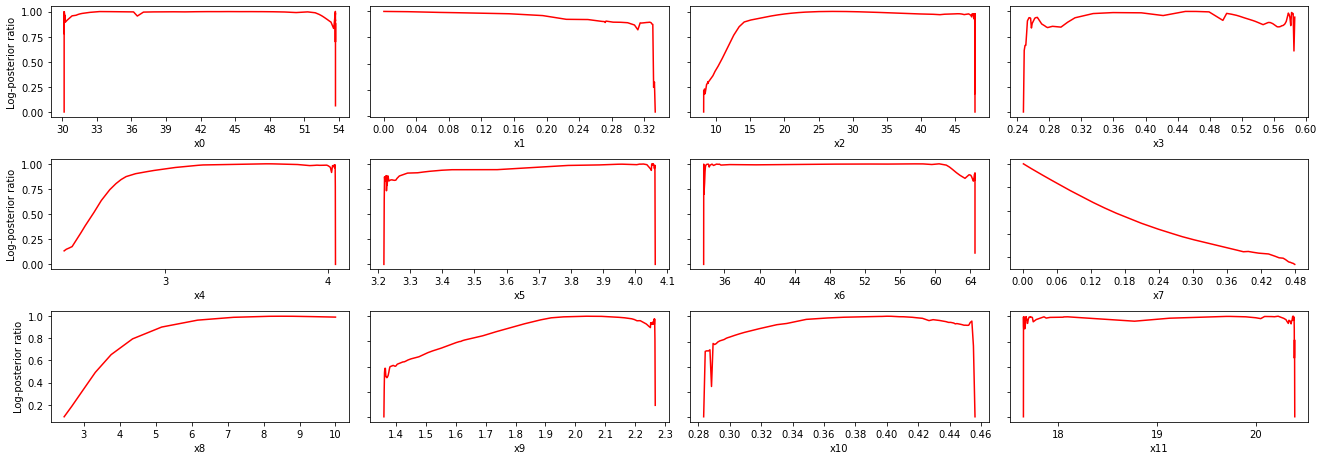

In [9]:
ax = visualize.profiles(result,)

## MCMC sampling 
-> decreasing the number of starts (n_start) will decrease the run time, but also effect the optimisation outcome

100%|██████████| 100000/100000 [49:13<00:00, 33.85it/s] 
Elapsed time: 2936.4707359999993


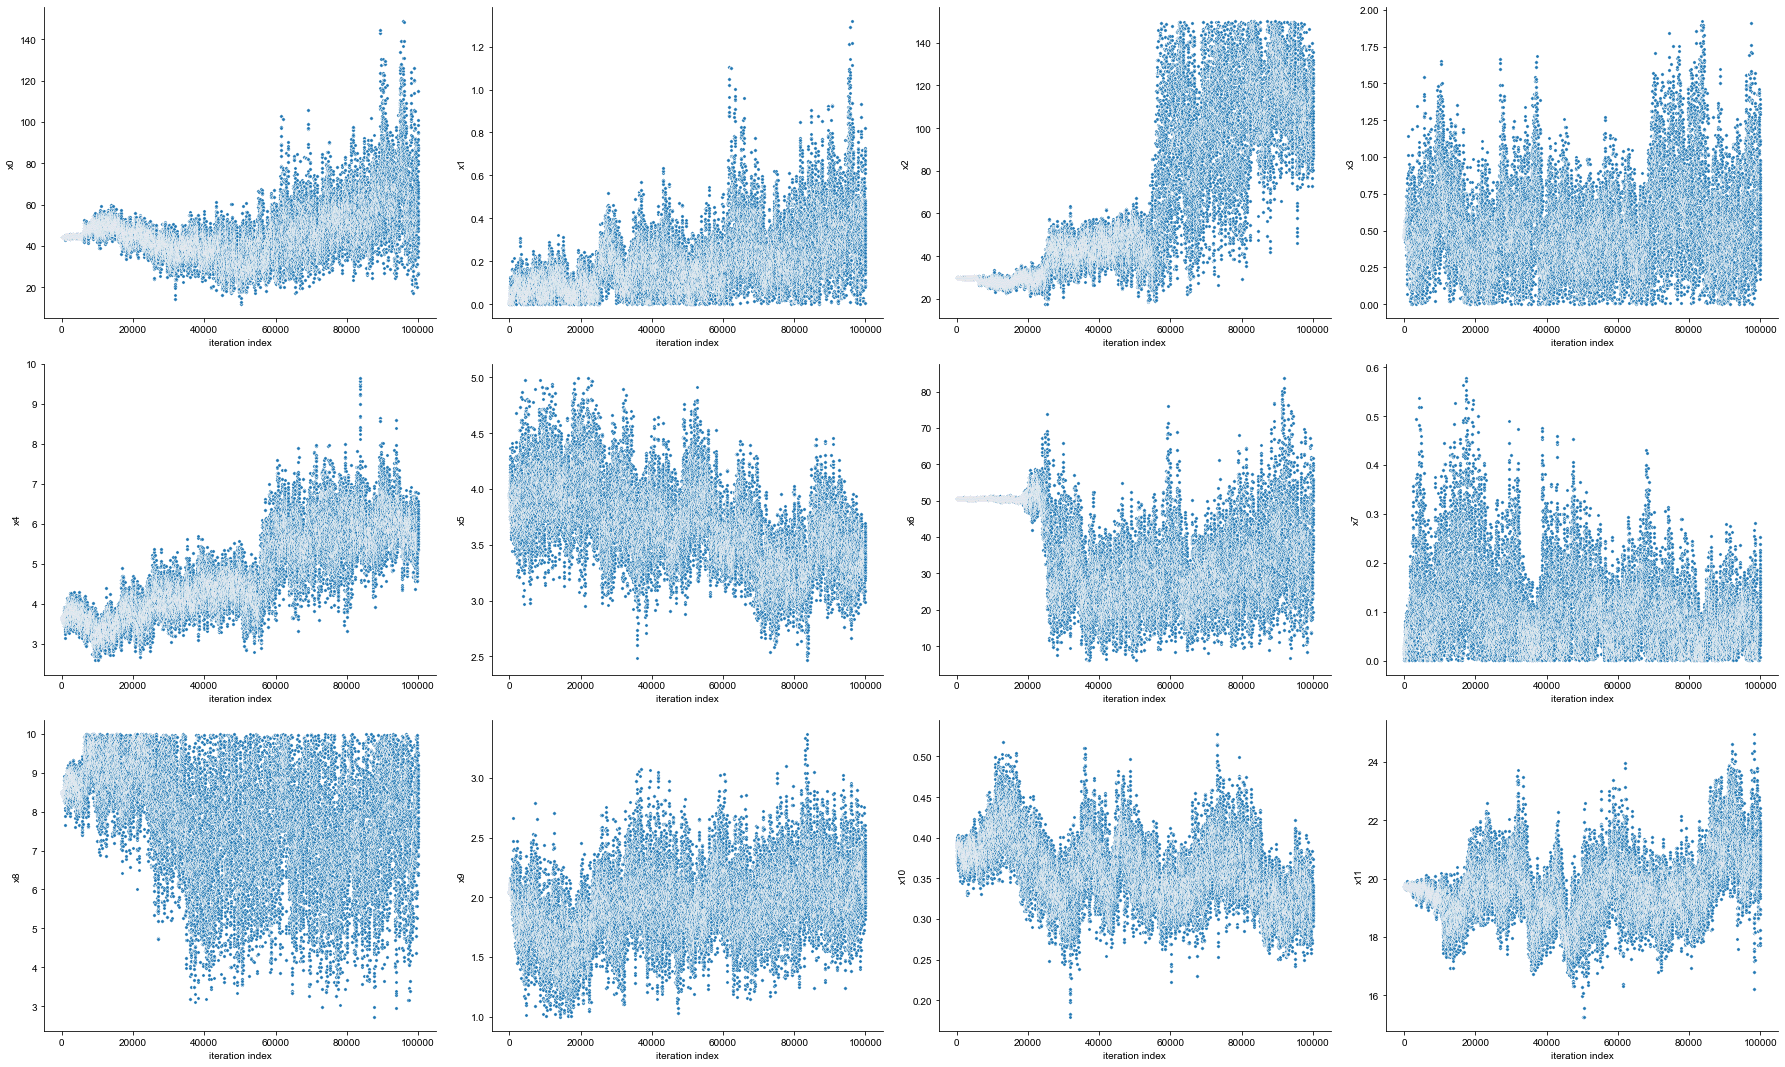

In [10]:
num_samples =100000

P = {"k_syn_FSH": df_optiresults['x'][0][0],
     "k_cl_FSH": df_optiresults['x'][0][1],
     "k_syn_E2": df_optiresults['x'][0][2],
     "k_cl_E2": df_optiresults['x'][0][3],
     "T_FSH_E2": df_optiresults['x'][0][4],
     "n_FSH_E2": df_optiresults['x'][0][5],
     "k_syn_LH": df_optiresults['x'][0][6],
     "k_cl_LH": df_optiresults['x'][0][7],
     "T_E2_LH": df_optiresults['x'][0][8],
     "n_E2_LH": df_optiresults['x'][0][9],
     "log_growth": df_optiresults['x'][0][10], 
     "log_mid": df_optiresults['x'][0][11]}

lb = np.array([0.000000001, 0.000000001, 0.000000001, 0.000000001, 0.00000001, 0.00000001, 0.000000001, 0.000000001
              , 0.000000001, 0.000000001, 0.000000001, 0.000000001])
ub = np.array([150.0, 10.0, 150.0, 10.0, 50.0, 10.0, 150.0, 10.0, 50.0, 10.0, 10.0, 50.0])

params = np.array(list(P.values()))

sampler = sample.AdaptiveParallelTemperingSampler(internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=3)
result = sample.sample(problem, n_samples=num_samples, sampler=sampler, x0=params, filename=None)

ax = visualize.sampling_parameter_traces(result, use_problem_bounds=False, size=(25, 15))

## Sobol Analysis 
create problem for Sobol analysis (https://salib.readthedocs.io/en/latest/getting-started.html)

In [21]:
# MLE used in Fischer-Holzhausen et al. 2023
## alternative the MLE saved in df_optiresults can be used 
df_optiresults_pub = pd.read_pickle('OptimizationResult.pkg')

def dy_dt(t, y, k_syn_FSH, k_cl_FSH, k_syn_E2, k_cl_E2, T_FSH_E2, n_FSH_E2, 
          k_syn_LH, k_cl_LH, T_E2_LH, n_E2_LH, sig_growth, sig_midpoint):

    FSH, E2, LH = y
    
    dFSH = k_syn_FSH * (1/(1+np.exp(-sig_growth*(t-sig_midpoint)))) - k_cl_FSH*FSH
    dE2 = k_syn_E2 * ((FSH/T_FSH_E2)**n_FSH_E2)/(1+(FSH/T_FSH_E2)**n_FSH_E2) - k_cl_E2*E2
    dLH = k_syn_LH * (1/(1+np.exp(-sig_growth*(t-sig_midpoint)))) * ((E2/T_E2_LH)**n_E2_LH)/(1+(E2/T_E2_LH)**n_E2_LH) - k_cl_LH*LH

    dydt = [dFSH, dE2, dLH]
    return dydt

k_syn_FSH = df_optiresults_pub['x'][0][0]
k_cl_FSH = df_optiresults_pub['x'][0][1]
k_syn_E2 = df_optiresults_pub['x'][0][2]
k_cl_E2 = df_optiresults_pub['x'][0][3]
T_FSH_E2 = df_optiresults_pub['x'][0][4]
n_FSH_E2 = df_optiresults_pub['x'][0][5]
k_syn_LH = df_optiresults_pub['x'][0][6]
k_cl_LH = df_optiresults_pub['x'][0][7]
T_E2_LH = df_optiresults_pub['x'][0][8]
n_E2_LH = df_optiresults_pub['x'][0][9]
sig_growth = df_optiresults_pub['x'][0][10]
sig_midpoint = df_optiresults_pub['x'][0][11]

problem = {
  'num_vars': 15, 
  'names': ['k_syn_FSH', 'k_cl_FSH', 'k_syn_E2', 'k_cl_E2', 'T_FSH_E2', 'n_FSH_E2',
            'k_syn_LH', 'k_cl_LH', 'T_LH_E2', 'n_E2_LH', 'sig_growth','sig_midpoint', 
            'x1_0', 'x2_0', 'x3_0'],
  'bounds':  np.column_stack((np.array([k_syn_FSH, k_cl_FSH, k_syn_E2, k_cl_E2, T_FSH_E2, 
                                        n_FSH_E2,k_syn_LH, k_cl_LH, T_E2_LH, n_E2_LH, sig_growth,sig_midpoint,
                                        y0[0], y0[1],y0[2]])*0.8,
                              np.array([k_syn_FSH, k_cl_FSH, k_syn_E2, k_cl_E2, T_FSH_E2, 
                                        n_FSH_E2, k_syn_LH, k_cl_LH, T_E2_LH, n_E2_LH, sig_growth,sig_midpoint,
                                        y0[0], y0[1], y0[2]])*1.2))
}

# Generate samples
##N should be a power of 2 value eg 512
N=11
vals = saltelli.sample(problem, 2**N, calc_second_order=False)

# initializing matrix to store output
Y = np.zeros((len(vals),3,len(t_eval)))

# Run model (example)
# numerically soves the ODE
# output is X1, X2, and X3 at the end time step
# could save output for all time steps if desired, but requires more memory

for i in range(len(vals)):
    sol = solve_ivp(dy_dt, t_span, [vals[i][12], vals[i][13], vals[i][14]], t_eval=t_eval, 
                    args=(vals[i][0], vals[i][1], vals[i][2], vals[i][3], vals[i][4], vals[i][5], 
                          vals[i][6], vals[i][7], vals[i][8], vals[i][9], vals[i][10], vals[i][11])).y
    for k in range(len(t_eval)): 
        Y[i,0,k] = sol[0][k]
        Y[i,1,k] = sol[1][k]
        Y[i,2,k] = sol[2][k]

### Calculate Sobol index at each time point for each parameter and species

In [22]:
FSH_total = np.zeros((15,len(t_eval)))
FSH_first = np.zeros((15,len(t_eval)))
E2_total = np.zeros((15,len(t_eval)))
E2_first = np.zeros((15,len(t_eval)))
LH_total = np.zeros((15,len(t_eval)))
LH_first = np.zeros((15,len(t_eval)))

for k in range(len(t_eval)): 
    Si_FSH = sobol.analyze(problem, Y[:,0, k], calc_second_order=False, print_to_console=False)
    Si_E2 = sobol.analyze(problem, Y[:,1, k], calc_second_order=False, print_to_console=False)
    Si_LH = sobol.analyze(problem, Y[:,2, k], calc_second_order=False, print_to_console=False)
    total, first = Si_FSH.to_df()
    FSH_total[:,k] = total['ST']
    FSH_first[:,k] = first['S1']
    total, first = Si_E2.to_df()
    E2_total[:,k] = total['ST']
    E2_first[:,k] = first['S1']
    total, first = Si_LH.to_df()
    LH_total[:,k] = total['ST']
    LH_first[:,k] = first['S1']

### Plot results as heatmaps

In [23]:
param_keys = ['k_syn_FSH', 'k_cl_FSH', 'k_syn_E2', 'k_cl_E2', '$T_{FSH}^{E2}$', '$n_{FSH}^{E2}$',
            'k_syn_LH', 'k_cl_LH', 'T_LH_E2', 'n_E2_LH', '$f_s$','$f_m$', 
            '$FSH_0$', '$E2_0$', '$LH_0$']

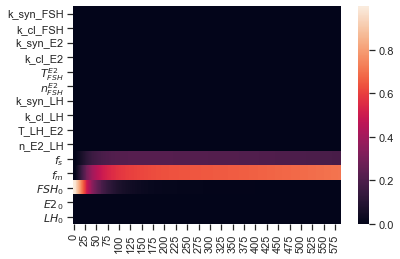

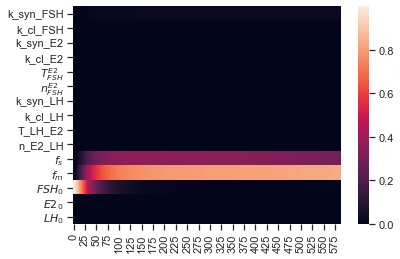

In [26]:
ax = sns.heatmap(FSH_first[:], yticklabels=param_keys)
plt.show()
ax = sns.heatmap(FSH_total[:], yticklabels=param_keys)
plt.show()

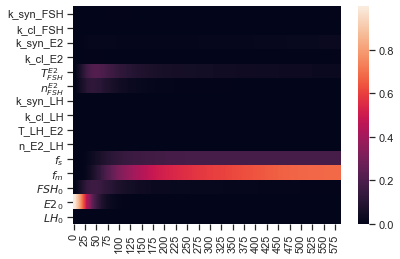

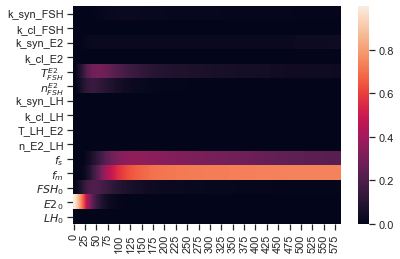

In [28]:
ax = sns.heatmap(E2_first[:], yticklabels=param_keys)
plt.show()
ax = sns.heatmap(E2_total[:], yticklabels=param_keys)
plt.show()

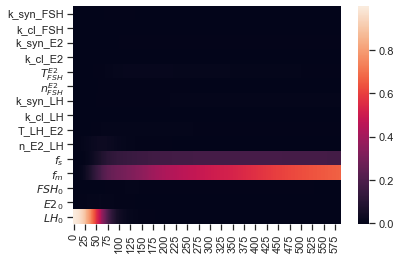

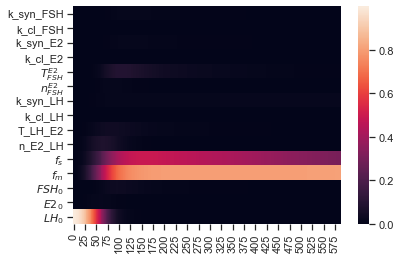

In [30]:
ax = sns.heatmap(LH_first[:], yticklabels=param_keys)
plt.show()
ax = sns.heatmap(LH_total[:], yticklabels=param_keys)
plt.show()